In [1]:
"""
Copyright 2018
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
    http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""

import numpy as np
import keras

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding1D
from keras.layers import MaxPooling1D, Lambda
from keras.layers.convolutional import UpSampling2D, Conv1D, Cropping1D
from keras.models import Sequential, Model
from keras.layers import MaxPooling1D, concatenate, Add
import keras.backend as K


import keras.utils
from keras.engine.topology import Layer
class Bias(Layer):
    def build(self, input_shape):
        self.bias = self.add_weight(shape=(input_shape[-1],),
                                        initializer="zeros",
                                        name='bias',
                                        regularizer=None,
                                        constraint=None)
        super(Bias, self).build(input_shape)
        
    def call(self, inputs):
        outputs = K.bias_add(
                inputs,
                self.bias)
        return outputs
    
    def compute_output_shape(self, input_shape):
        return input_shape


keras.layers.Bias = Bias

def partial_convolution(input_, mask, filters, shape, stride, activation):
    convolution_layer = Conv1D(filters, shape, strides=stride, use_bias=False,
                               padding="same")
    
    mask_sum_layer = Conv1D(filters, shape, strides=stride, 
                                  padding="same", 
                                  weights=[np.ones((shape[0], input_.shape[-1], filters)),
                                           np.zeros((filters,))])
    
    mask_sum_layer.trainable = False
    
    mask_sum = mask_sum_layer(mask)
    
    new_mask = Lambda(lambda x: K.clip(x, 0, 1))(mask_sum)
    
    output = convolution_layer(keras.layers.multiply([mask, input_]))
    
    inv_sum = Lambda(lambda x: filters * shape[0] / (.0001 + x))(mask_sum) 
    
    output = keras.layers.multiply([output, inv_sum])
    
    output = Bias()(output)
    
    output = activation(output)
    
    return output, new_mask

def normal_convolution(input_, mask, filters, shape, stride, activation):
    convolution_layer = Conv1D(filters, shape, strides=stride,
                               padding="same")
    
    output = convolution_layer(input_)
    
    output = activation(output)
    
    return output, mask

def residual_block(input_, mask):
    output, new_mask = normal_convolution(input_, mask, 512, (3,), 1, Activation("relu"))
    output, new_mask = normal_convolution(output, new_mask, 512, (3,), 1, Activation("relu"))
    output, new_mask = normal_convolution(output, new_mask, int(input_.shape[-1]), (3,), 1, Activation("relu"))
    output = keras.layers.Add()([output, input_])
    new_mask = keras.layers.Add()([mask, new_mask])
    new_mask = Lambda(lambda x: K.clip(x, 0, 1))(new_mask)
    return output, new_mask
    

def sequence_unet(patch_size=256, dim=36):
    
    global sequence_unet_input
    global sequence_unet_input_mask
    input_ = Input((patch_size, dim))
    sequence_unet_input = input_
    input_mask = Input((patch_size, dim))
    sequence_unet_input_mask = input_mask
    skips = []
    output = input_
    mask = input_mask
    for shape, filters in zip([7, 5, 5, 3, 3, 3, 3, 3], [64, 128, 256, 256, 256, 256, 256, 256]):
        skips.append((output, mask))
        print(output.shape)
        output, mask = partial_convolution(output, mask, filters, (shape,), 2,
                                           Activation("relu"))
        if shape != 7:
            output = BatchNormalization()(output)
    for shape, filters in zip([4, 4, 4, 4, 4, 4, 4, 4], [256, 256, 256, 256, 256, 128, 64, dim]):
        output = keras.layers.UpSampling1D()(output)
        mask = keras.layers.UpSampling1D()(mask)
        skip_output, skip_mask = skips.pop()
        output = concatenate([output, skip_output], axis=2)
        mask = concatenate([mask, skip_mask], axis=2)
        
        if filters != dim:
            activation = keras.layers.LeakyReLU(.2)
        else:
            activation = Activation("linear")
        output, mask = partial_convolution(output, mask, filters, (shape,), 1, activation)
        #output, mask = residual_block(output, mask)
        if filters != dim:
            output = BatchNormalization()(output)
    assert len(skips) == 0
    return Model([input_, input_mask], [output])




/home/hastings/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
class Game:
    def __init__(self, name, use_vae, num_controls, num_obs_dims, experience_file, vae_file = None,
                unet_length = 256):
        self.name = name
        self.use_vae = use_vae
        self.num_controls = num_controls
        self.num_obs_dims = num_obs_dims
        self.experience_file = experience_file
        self.vae_file = vae_file
        self.fulldata_dim = num_controls + num_obs_dims + 1
        self.unet_length = unet_length
game = Game("CarRacing-v0", True, 3, 32, "more_runs.pickle", "vae_cnn_mnist.h5", 256)
#game = Game("BipedalWalker-v2", False, 4, 24, "some_walks.pickle", None, 256)

In [3]:
network = sequence_unet(game.unet_length, game.fulldata_dim)


(?, 256, 36)
(?, 128, 64)
(?, 64, 128)
(?, 32, 256)
(?, 16, 256)
(?, 8, 256)
(?, 4, 256)
(?, 2, 256)


In [4]:
import pickle
class Run:
    def __init__(self):
        self.obs_l = []
        self.reward_l = []
        self.action_l = []
some_runs = pickle.load(open(game.experience_file, "rb"))


In [5]:
for run in some_runs:
    run.obs_l = np.array(run.obs_l)

In [6]:
K.zeros

<function keras.backend.tensorflow_backend.zeros(shape, dtype=None, name=None)>

In [7]:
import vae
if(game.use_vae):
    vae.vae.load_weights(game.vae_file)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 47, 47, 32)   1568        encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 22, 22, 64)   32832       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 10, 10, 128)  131200      conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

In [8]:
import cv2
decoded = vae.decoder.predict(some_runs[20].obs_l[0])
for im in decoded:
    cv2.imshow("hi", im)
    if cv2.waitKey(10) != -1:
        break

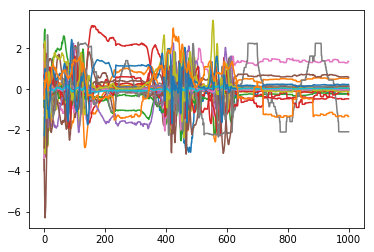

In [9]:
import matplotlib.pyplot as plt
plt.plot(some_runs[2000].obs_l[0])
plt.show()

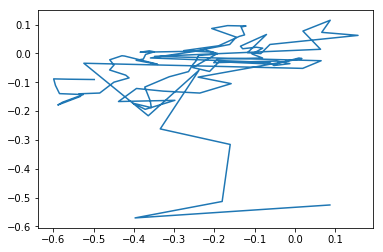

In [10]:
obs_l = some_runs[41].obs_l[0]
plt.plot(obs_l[:100, 0], obs_l[:100, 10])
plt.show()

In [11]:
from noise import pnoise1
def makeNoise(l):
    start = np.random.random() * 10000
    out = []
    for _ in range(l):
        a = pnoise1(_ / 140 + start, 5)
        out.append(a)
    return np.array(out)
def mask():
    m1 = makeNoise(256) > 0
    m1 = m1.reshape (256, 1)
    m1 = np.repeat(m1,3, 1)
    
    m2 = makeNoise(256) > 0
    m2 = m2.reshape (256, 1)
    m2 = np.repeat(m2, 32, 1)
    
    m3 = makeNoise(256) > 0
    m3 = m3.reshape (256, 1)
    #m3 = np.repeat(m, 36, 1)
    #m[:, :3] = 1
    return np.concatenate([m1, m2, m3], -1)

def mask():
    m = makeNoise(256) > 0
    m = m.reshape (256, 1)
    m = np.repeat(m, game.fulldata_dim, 1)
    m[:, :game.num_controls] = 1
    return m

In [12]:
full_data = [
    np.concatenate([
        r.action_l[:r.obs_l[0].shape[0]], 
        r.obs_l[0], 
        np.arctan(np.expand_dims(r.reward_l, 1))
    ], axis=1) 
    for r in some_runs
]
for i in range(len(full_data)):
    if len(full_data[i]) <= 256:
        
        full_data[i] = np.concatenate([
            full_data[i], 
            np.repeat(full_data[i][-1:], 300 - len(full_data[i]), axis=0)
        ], axis=0)
        
        
print(len(full_data))

10000


In [13]:
full_data = [
    np.concatenate([
        r.action_l[:r.obs_l[0].shape[0]], 
        r.obs_l[0], 
        np.expand_dims(r.reward_l, 1)
    ], axis=1) 
    for r in some_runs
    if len(r.reward_l) > 256
]
print(len(full_data))

9996


In [14]:
data_starts = [np.random.randint(0, len(ar) - 256) for ar in full_data]
data_cropped = np.array([f[start:256 + start] for f, start in zip(full_data, data_starts)])
masks = np.array([mask() for _ in range(len(data_cropped))])

In [15]:
network.compile(loss=keras.losses.mse, optimizer=keras.optimizers.adam(), metrics=[keras.losses.mse])

In [19]:
"""for _ in range(280):
    data_starts = [np.random.randint(0, len(ar) - 256) for ar in full_data]
    data_cropped = np.array([f[start:256 + start] for f, start in zip(full_data, data_starts)])
    masks = np.array([control_mask(128)[0] for _ in range(len(data_cropped))])
    
    network.fit([data_cropped[:-200], masks[:-200]], data_cropped[:-200], validation_data=
               ([data_cropped[-200:], masks[-200:]], data_cropped[-200:]))"""

import random
modelRuns = []
for _ in range(200080):
    #modelRuns.append(modelRun())
    
    for __ in range(100):
        idx = np.random.randint(0, len(full_data) - 200, 128)
        #print(idx)
        round_data = [full_data[i] for i in idx]
        data_starts = [np.random.randint(0, len(ar) - 256) for ar in round_data]
        data_cropped = np.array([f[start:256 + start] for f, start in zip(round_data, data_starts)])
        masks = np.array([
            mask() if random.random() < .5 else control_mask(random.randint(100, 150)) [0]
            for _ in range(len(data_cropped))])

        network.train_on_batch([data_cropped, masks], data_cropped)
    print(network.train_on_batch([data_cropped, masks], data_cropped))


[0.14561406, 0.14561407]
[0.11283127, 0.11283127]
[0.11413399, 0.114133984]
[0.09504621, 0.09504621]
[0.094437376, 0.09443736]
[0.09285198, 0.092851974]
[0.080640346, 0.08064035]
[0.08738041, 0.08738041]
[0.07966922, 0.07966922]
[0.08388777, 0.08388778]
[0.084175214, 0.084175214]
[0.07434979, 0.07434979]
[0.07678457, 0.07678457]
[0.07422064, 0.07422064]
[0.07667472, 0.07667472]
[0.066928424, 0.066928424]
[0.07412179, 0.07412179]
[0.073084466, 0.073084466]
[0.06895811, 0.0689581]
[0.07041703, 0.07041703]
[0.06759063, 0.06759063]
[0.065730035, 0.065730035]
[0.06524504, 0.06524504]
[0.07086773, 0.070867725]
[0.072747536, 0.07274754]
[0.06238447, 0.062384468]


KeyboardInterrupt: 

In [55]:
final_val_loss=.0165

In [18]:
modelRun()

NameError: name 'modelRun' is not defined

In [20]:
data_out = network.predict([data_cropped, masks])

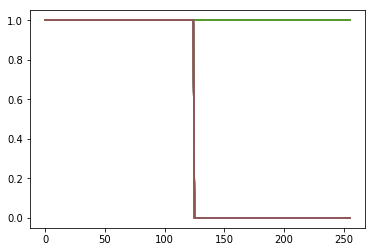

In [22]:
import cv2
def watch(fulld):
    
    decoded = vae.decoder.predict(fulld[:, 3:35])
    for im in decoded:
        cv2.imshow("hi", im)
        if cv2.waitKey(10) != -1:
            break
plt.plot(masks[-1])
plt.show()
if(game.use_vae):
    watch(data_cropped[-1])


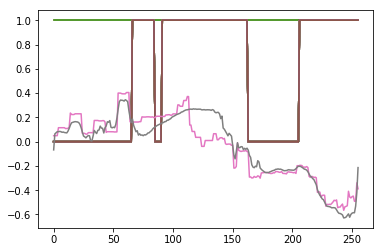

In [23]:
j = np.random.randint(0, 100)

plt.plot(masks[j])
plt.plot(data_cropped[-j,:,  -10])
plt.plot(data_out[-j,:,  -10])
plt.show()


In [24]:
watch(data_cropped[-j])
watch(data_out[-j])

In [25]:
def control_mask(len_init):
    out = np.concatenate([np.ones(len_init), np.zeros(256 - len_init)])
    out = out.reshape(1, 256, 1)
    out = np.repeat(out, game.fulldata_dim, 2)
    out[:,:, :game.num_controls] = 1
    return out

In [26]:
def apply_action(full_data, len_init, action):
    out = full_data.copy()
    
    out[:, len_init:, :game.num_controls] = np.array(action).reshape(len(out), -1, game.num_controls)
    return out

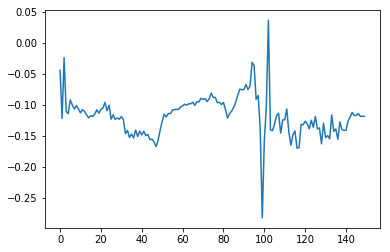

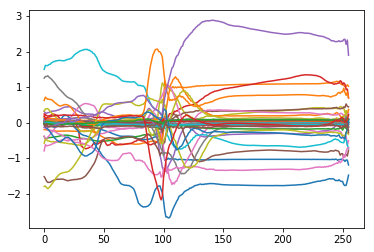

In [27]:

n = 101
control_out = network.predict([apply_action(data_cropped[-n:-n + 1], 100, [-1, 1, 0]), control_mask(100)])
watch(control_out[0, :256])
plt.plot(control_out[0, 0:150, -1])
score8 = np.sum(control_out[0, 100:115, -1])
score8
plt.show()
plt.plot(control_out[0])
plt.show()

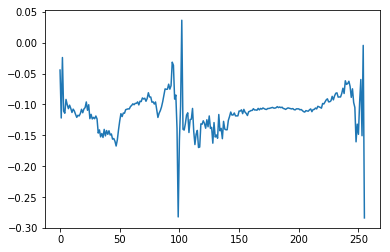

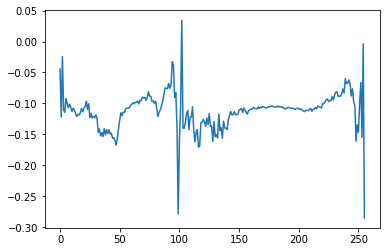

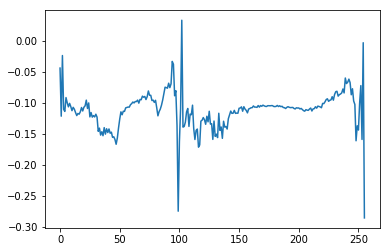

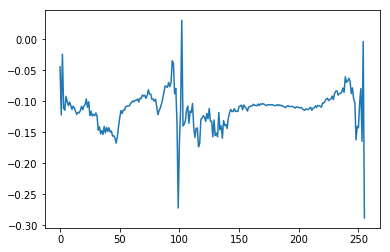

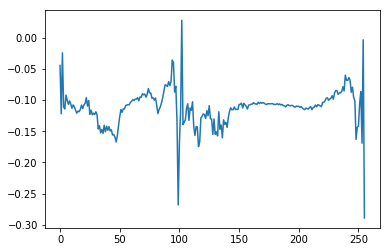

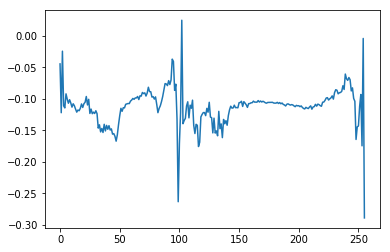

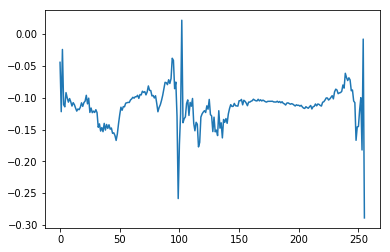

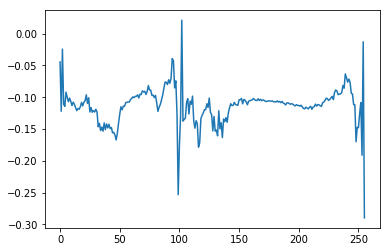

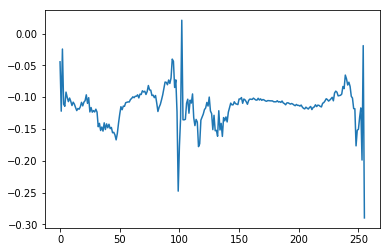

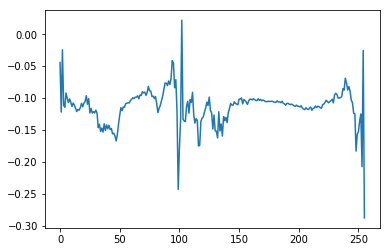

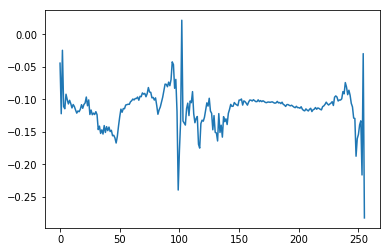

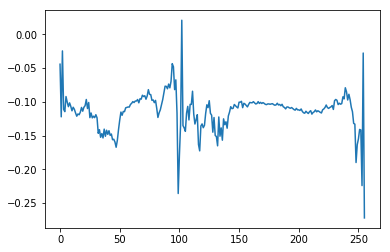

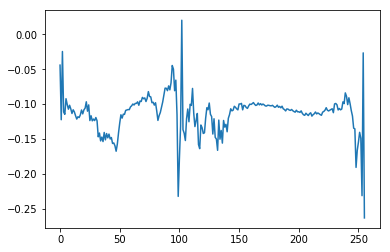

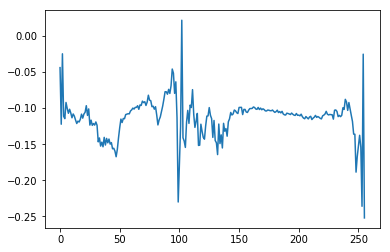

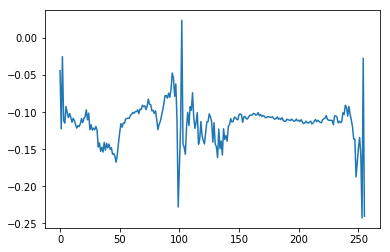

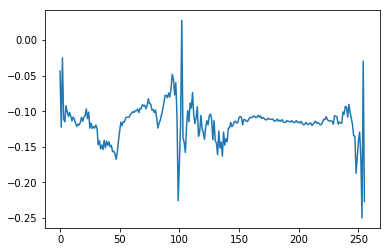

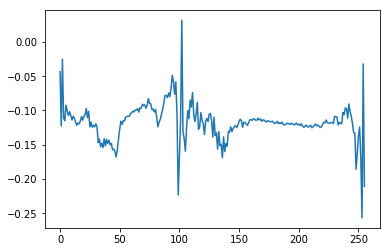

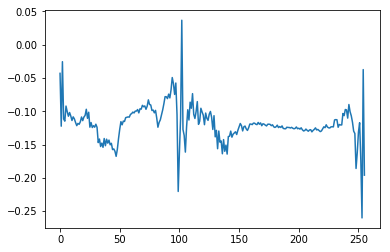

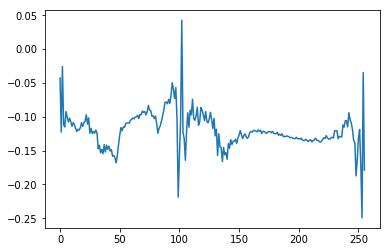

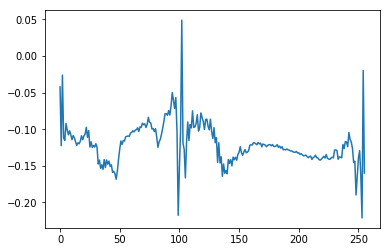

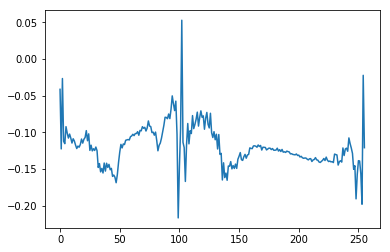

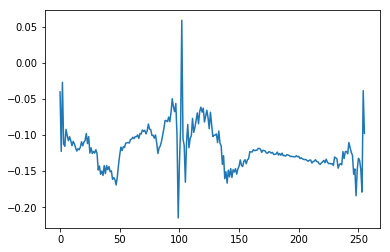

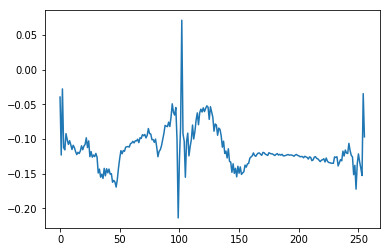

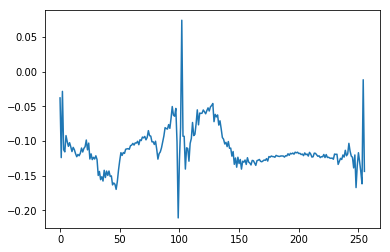

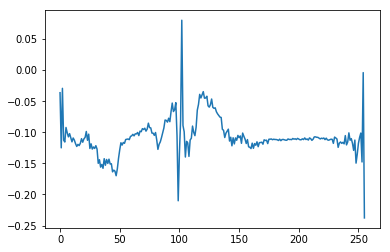

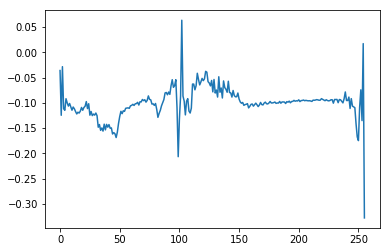

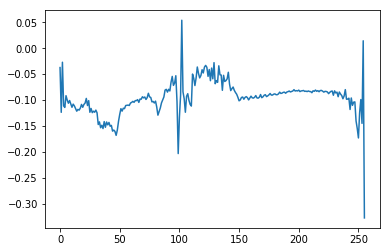

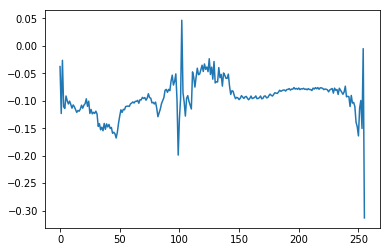

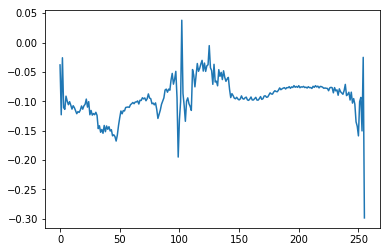

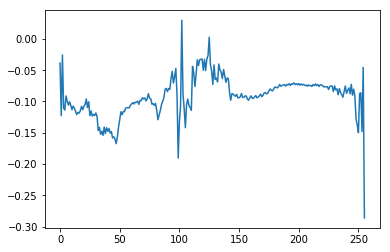

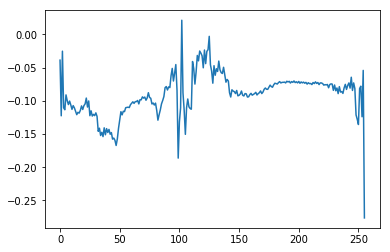

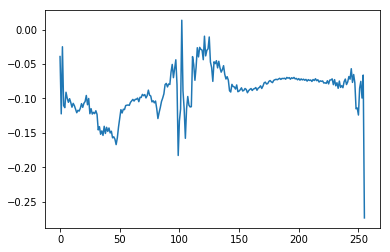

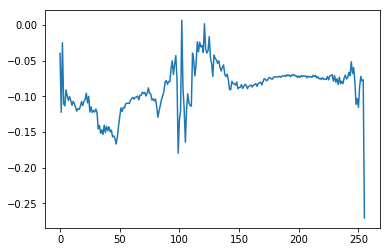

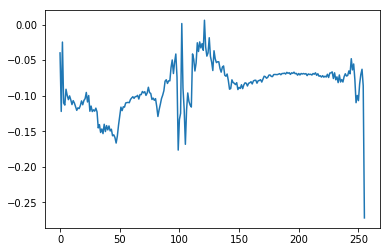

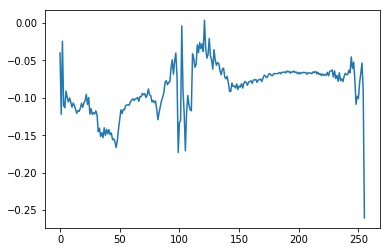

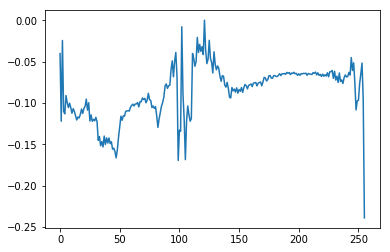

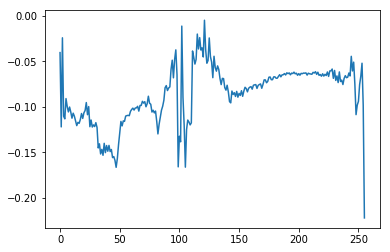

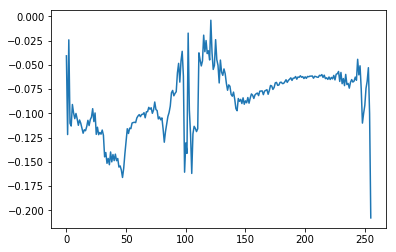

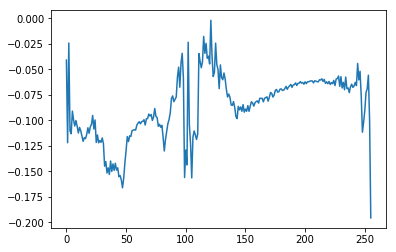

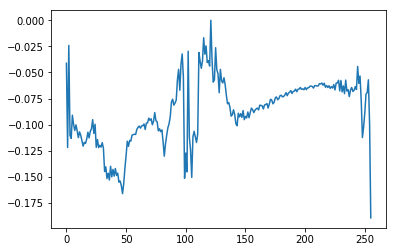

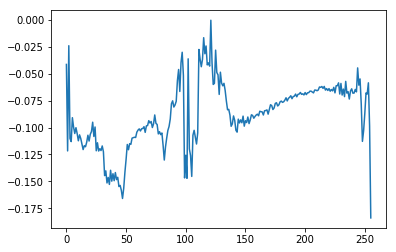

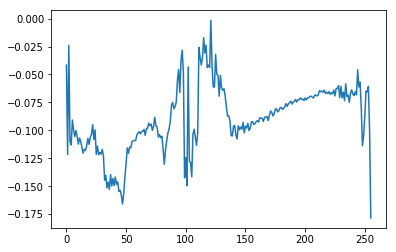

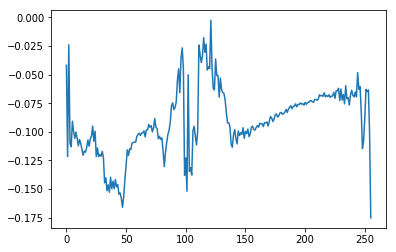

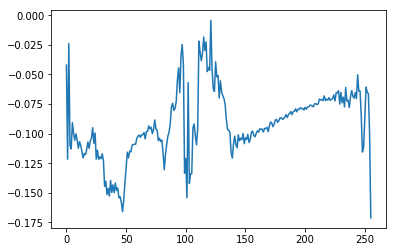

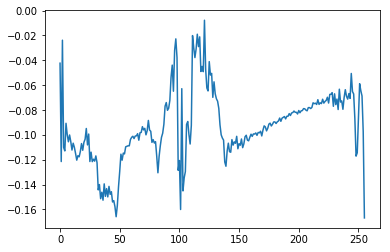

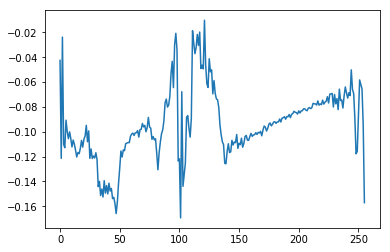

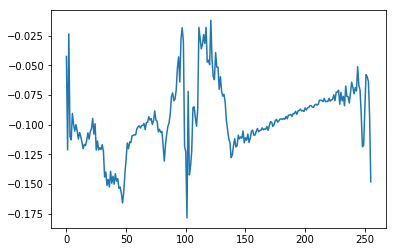

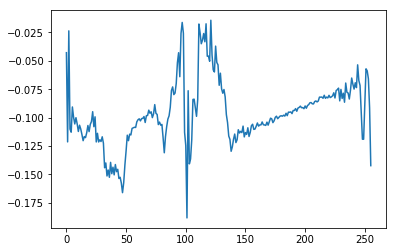

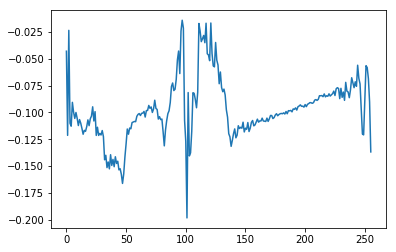

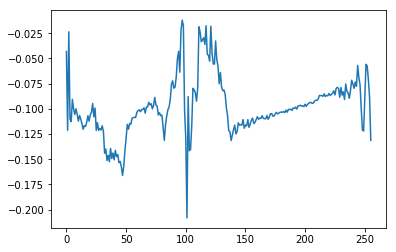

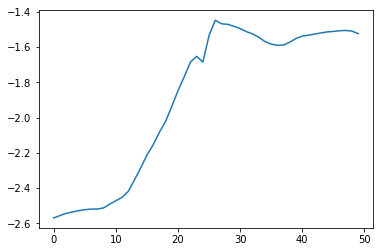

In [397]:
def score(full_data, len_init, action, do_watch=False):
    
    network_out = network.predict([
        apply_action(full_data, len_init, action),
        np.repeat(control_mask(len_init), len(np.reshape(action, (-1, 1, game.num_controls))), 0)
    ])
    if(do_watch):
        watch(network_out[0, len_init:])
        plt.plot(network_out[0, :, -1])
        plt.show()
    score = np.sum(network_out[:, len_init:len_init + 20, -1], axis=1)
    return score
plt.plot([score(data_cropped[-n:-n + 1], 100, [ctrl,  1, 0], True) for ctrl in np.linspace(-1, 1, 50)])
plt.show()


In [389]:
import noise
import gym
import matplotlib.pyplot as plt
import numpy as np




env = gym.make(game.name)
from pyglet import gl
import cProfile
_ = env.reset()


Track generation: 1024..1284 -> 260-tiles track


In [30]:
env.action_space.sample()

array([0.09762701, 0.71518934, 0.60276335], dtype=float32)

In [31]:
env.action_space.low

array([-1.,  0.,  0.], dtype=float32)

In [398]:
def makeActionArray():
    start = np.random.random(4) * 10000
    out = []
    for _ in range(2000):
        action = [ 1.7 * pnoise1(_ / 200 + start_i, 5) for start_i in start]
        out.append(action)
    return np.array(out)

def choose_action(state, len_init):
    candidate_actions = [env.action_space.sample() for _ in range(60)]
    #for ac in candidate_actions:
     #   ac[2] = 0
    
    scores = score(
        np.repeat(np.expand_dims(state, 0),len(candidate_actions), 0), 
        len_init, candidate_actions
    ) 
    if(np.random.random() < .0):
        score(np.expand_dims(state, 0), len_init, candidate_actions[np.argmax(scores):np.argmax(scores) + 1], do_watch=True)
    
    return candidate_actions[np.argmax(scores)]

In [33]:
choose_action(data_cropped[-n], 100)

array([0.13608912, 0.92559665, 0.07103606], dtype=float32)

In [399]:
def modelRun(encoded=False):
    _ = env.reset()
    done = False
    run = Run()
    i = 0
    
    def encode(obs):
        if game.use_vae:
            return vae.encoder.predict(np.array(obs) / 255.)[0]
        else:
            return obs
    
    
    while not done:
        if i == 0:
            full_state = np.zeros((256, game.fulldata_dim))
        elif i < 128:
            full_state = np.concatenate([
                run.action_l, 
                encode(run.obs_l), 
                np.expand_dims(run.reward_l, 1)
            ], axis=1) 
            full_state = np.concatenate([
                full_state,
                np.zeros((256 - i, game.fulldata_dim))
            ])
        else: 
            full_state = np.concatenate([
                run.action_l[-128:], 
                encode(run.obs_l[-128:]), 
                np.expand_dims(run.reward_l[-128:], 1)
            ], axis=1) 
            full_state = np.concatenate([
                full_state,
                np.zeros((128, game.fulldata_dim))
            ])
        action = choose_action(full_state, np.min([i, 128]))
        #print(run.reward_l[-1:], action, i,  end="                  \r")
        i += 1
        obs, reward, done, _ = env.step(action)
        run.action_l.append(action)
        
        run.obs_l.append(obs)
        run.reward_l.append(reward)
        if (len(run.reward_l) % 5 == 0):
            env.render()
    if encoded:
        run.obs_l = vae.encoder.predict(np.array(run.obs_l) / 255.)
    return run

runs = [modelRun() for i in range(500)]
modelRun()

Track generation: 1116..1408 -> 292-tiles track
Track generation: 1166..1461 -> 295-tiles track
Track generation: 1152..1451 -> 299-tiles track
Track generation: 1138..1433 -> 295-tiles track
Track generation: 1207..1513 -> 306-tiles track
Track generation: 1208..1514 -> 306-tiles track
Track generation: 1086..1367 -> 281-tiles track
Track generation: 1101..1388 -> 287-tiles track
Track generation: 1084..1359 -> 275-tiles track
Track generation: 1187..1488 -> 301-tiles track
Track generation: 1231..1549 -> 318-tiles track
Track generation: 1219..1538 -> 319-tiles track
Track generation: 1151..1443 -> 292-tiles track
Track generation: 1122..1407 -> 285-tiles track
Track generation: 972..1221 -> 249-tiles track
retry to generate track (normal if there are not many of this messages)
Track generation: 1388..1739 -> 351-tiles track
Track generation: 1291..1618 -> 327-tiles track
Track generation: 1132..1419 -> 287-tiles track
Track generation: 1063..1333 -> 270-tiles track
Track generation:

Track generation: 1226..1537 -> 311-tiles track
Track generation: 1184..1484 -> 300-tiles track
Track generation: 1164..1459 -> 295-tiles track
Track generation: 1162..1462 -> 300-tiles track
Track generation: 1108..1389 -> 281-tiles track
Track generation: 1205..1511 -> 306-tiles track
Track generation: 1154..1448 -> 294-tiles track
Track generation: 1194..1497 -> 303-tiles track
Track generation: 1212..1526 -> 314-tiles track
Track generation: 1128..1414 -> 286-tiles track
Track generation: 1113..1401 -> 288-tiles track
Track generation: 1016..1277 -> 261-tiles track
retry to generate track (normal if there are not many of this messages)
Track generation: 1156..1449 -> 293-tiles track
Track generation: 1164..1459 -> 295-tiles track
Track generation: 1151..1443 -> 292-tiles track
Track generation: 1182..1482 -> 300-tiles track
Track generation: 1086..1368 -> 282-tiles track
Track generation: 1117..1400 -> 283-tiles track
Track generation: 1204..1509 -> 305-tiles track
Track generation

Track generation: 1079..1352 -> 273-tiles track
Track generation: 1338..1676 -> 338-tiles track
Track generation: 1037..1300 -> 263-tiles track
Track generation: 1059..1335 -> 276-tiles track
Track generation: 1343..1683 -> 340-tiles track
Track generation: 1216..1524 -> 308-tiles track
Track generation: 1158..1461 -> 303-tiles track
Track generation: 1200..1505 -> 305-tiles track
Track generation: 1212..1519 -> 307-tiles track
Track generation: 1109..1396 -> 287-tiles track
Track generation: 1207..1513 -> 306-tiles track
Track generation: 1239..1553 -> 314-tiles track
Track generation: 1175..1473 -> 298-tiles track
Track generation: 1179..1478 -> 299-tiles track
Track generation: 1104..1384 -> 280-tiles track
Track generation: 1174..1476 -> 302-tiles track
Track generation: 1111..1393 -> 282-tiles track
Track generation: 1228..1539 -> 311-tiles track
Track generation: 1267..1588 -> 321-tiles track
Track generation: 1215..1523 -> 308-tiles track
Track generation: 1216..1524 -> 308-tile

Track generation: 1068..1339 -> 271-tiles track
Track generation: 1136..1424 -> 288-tiles track
Track generation: 1148..1439 -> 291-tiles track
Track generation: 1138..1427 -> 289-tiles track
Track generation: 1033..1303 -> 270-tiles track
Track generation: 1175..1478 -> 303-tiles track
Track generation: 1159..1453 -> 294-tiles track
Track generation: 1309..1641 -> 332-tiles track
Track generation: 1088..1364 -> 276-tiles track
Track generation: 941..1190 -> 249-tiles track
Track generation: 1316..1649 -> 333-tiles track
Track generation: 1160..1460 -> 300-tiles track
Track generation: 929..1172 -> 243-tiles track
Track generation: 1072..1344 -> 272-tiles track
Track generation: 1256..1574 -> 318-tiles track
Track generation: 1124..1409 -> 285-tiles track
Track generation: 1259..1578 -> 319-tiles track
Track generation: 1176..1474 -> 298-tiles track
Track generation: 1033..1295 -> 262-tiles track
Track generation: 1289..1615 -> 326-tiles track
Track generation: 1015..1273 -> 258-tiles 

In [374]:
def make_policy_network():
    model = keras.Sequential()
    model.add(keras.layers.Dense(15, input_shape=(64,), activation='relu'))
    model.add(keras.layers.Dense(15, input_shape=(64,), activation='relu'))
    model.add(keras.layers.Dense(3))
    model.compile(loss=keras.losses.mse, optimizer=keras.optimizers.adam())
    return model
policy_network = make_policy_network()
    

In [386]:
for _ in range(10):
    for run in runs:
        observations = vae.encoder.predict(np.array(run.obs_l) / 255)[0]
        observations = np.concatenate([observations[:-5], observations[5:]], 1)
        actions = np.array(run.action_l)[5:]
        policy_network.fit(observations, actions)

Epoch 1/1
995/995 [==============================] - 0s 47us/step - loss: 0.0295
Epoch 1/1
995/995 [==============================] - 0s 52us/step - loss: 0.0271
Epoch 1/1
995/995 [==============================] - 0s 142us/step - loss: 0.0256
Epoch 1/1
995/995 [==============================] - 0s 68us/step - loss: 0.0251
Epoch 1/1
995/995 [==============================] - 0s 73us/step - loss: 0.0244
Epoch 1/1
995/995 [==============================] - 0s 66us/step - loss: 0.0239
Epoch 1/1
995/995 [==============================] - 0s 46us/step - loss: 0.0235
Epoch 1/1
995/995 [==============================] - 0s 130us/step - loss: 0.0235
Epoch 1/1
995/995 [==============================] - 0s 48us/step - loss: 0.0232
Epoch 1/1
995/995 [==============================] - 0s 138us/step - loss: 0.0230


In [354]:
modelRun()

Track generation: 1381..1730 -> 349-tiles track


KeyboardInterrupt: 

In [ ]:
with open("high_quality_runs.pickle", "wb") as f:
    pickle.dump(runs, f)

In [394]:
def modelRun(encoded=False):
    _ = env.reset()
    done = False
    run = Run()
    i = 0
    
    def encode(obs):
        if game.use_vae:
            return vae.encoder.predict(np.array(obs) / 255.)[0]
        else:
            return obs
    
    
    while not done:
        if i < 6:
            action = [0, 0, 0]
        else: 
            print(np.array([run.obs_l[-2], obs]).shape)
            encoded_obs = encode(np.array([run.obs_l[-6], obs]))
            seq = np.concatenate([encoded_obs[0], encoded_obs[1]])
            #print(seq)
                  
            action = (policy_network.predict(np.array([seq]))[0] + 
                (np.random.random(3) - .5) / 500)
        #print(run.reward_l[-1:], action, i,  end="                  \r")
        #action[2] = 0
        #action[1] = .02
        for _ in range(1):
            i += 1
            obs, reward, done, _ = env.step(action)
            run.action_l.append(action)

            run.obs_l.append(obs)
            run.reward_l.append(reward)
            if (len(run.reward_l) % 5 == 0):
                env.render()
    if encoded:
        run.obs_l = vae.encoder.predict(np.array(run.obs_l) / 255.)
    return run

run = modelRun()

Track generation: 1275..1598 -> 323-tiles track
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96, 96, 3)
(2, 96,

AttributeError: 'Model' object has no attribute 'shape'

array([9006, 4911, 3157, 7144,   16, 5367, 4751,  707, 3297, 4381, 1208,
       2112, 6987, 2346, 7323, 9056, 5646, 7009, 5646, 6722, 5989, 8105,
       3687, 9361, 7689, 7915, 7844, 6820, 8740,  733,  135, 6488,   49,
       6103,  261,  200, 8525, 1550, 4043, 7134, 4474, 1530, 8814, 2557,
       2412, 9168,  333, 2069, 2827, 2723])

In [40]:
np.array(full_data[-1:]).shape
test = np.repeat(full_data[-1:], 2, 0)

test.shape
test = test[:, :256, :]
watch(test[0])
test[0][mask[0] == 0] = 1000
mask = np.repeat(control_mask(128), 2, 0)

out = network.predict([test, mask])

watch(out[0])
plt.plot(mask[0])
plt.plot(test[0][:, -2])
plt.plot(out[1][:, -2])

TypeError: 'function' object is not subscriptable

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)